
Random Forest Results
              precision    recall  f1-score   support

           1       0.90      0.86      0.88      1945
           2       0.95      0.96      0.96      5499
           3       0.85      0.80      0.82       432
           4       0.92      0.97      0.94       432
           5       0.90      0.85      0.87       483
           6       0.81      0.87      0.84       432
           7       0.95      0.95      0.95       432

    accuracy                           0.93      9655
   macro avg       0.90      0.89      0.90      9655
weighted avg       0.93      0.93      0.93      9655



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:56:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Results
              precision    recall  f1-score   support

           1       0.89      0.84      0.86      1945
           2       0.94      0.96      0.95      5499
           3       0.80      0.79      0.80       432
           4       0.95      0.97      0.96       432
           5       0.85      0.82      0.84       483
           6       0.77      0.83      0.80       432
           7       0.94      0.94      0.94       432

    accuracy                           0.91      9655
   macro avg       0.88      0.88      0.88      9655
weighted avg       0.91      0.91      0.91      9655



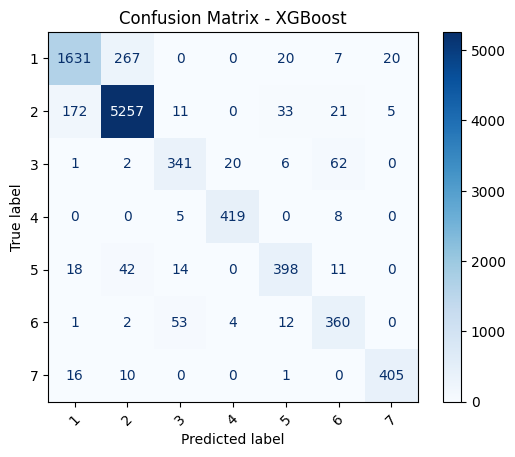

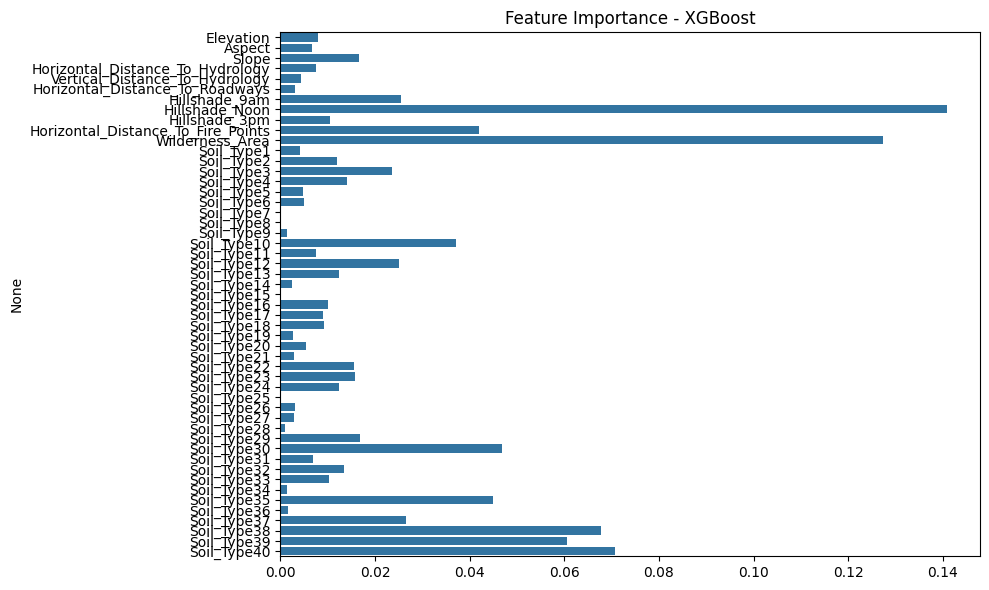

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# -------------------------
# Load dataset
# -------------------------
df = pd.read_csv("covertype.csv")

# Drop useless index-like columns if present
df.drop(columns=["Unnamed: 0", "Unnamed: 1", "Unnamed: 2"], inplace=True, errors="ignore")

# Drop rows with missing values in target
df.dropna(subset=['Cover_Type'], inplace=True)

# -------------------------
# Features & Target
# -------------------------
X = df.drop("Cover_Type", axis=1)
y = df["Cover_Type"].astype(int) - 1   # shift to 0–6

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# -------------------------
# Random Forest
# -------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("\nRandom Forest Results")
print(classification_report(y_test + 1, y_pred_rf + 1))  # shift back to 1–7 for readability

# -------------------------
# XGBoost
# -------------------------
xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y)),  # should be 7
    eval_metric="mlogloss",
    random_state=42,
    use_label_encoder=False
)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

print("\nXGBoost Results")
print(classification_report(y_test + 1, y_pred_xgb + 1))  # back to 1–7

# Confusion Matrix
cm = confusion_matrix(y_test + 1, y_pred_xgb + 1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - XGBoost")
plt.show()

# -------------------------
# Feature Importance (XGBoost)
# -------------------------
importances = xgb.feature_importances_
features = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features, orient="h")
plt.title("Feature Importance - XGBoost")
plt.tight_layout()
plt.show()

# -------------------------
# Hyperparameter Tuning (Random Forest)
# -------------------------
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid.fit(X_train_scaled, y_train)

print("\nBest Parameters:", grid.best_params_)
print("Best Score (CV accuracy):", grid.best_score_)